<a href="https://colab.research.google.com/github/ItsMacto/ML-Models/blob/main/MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exploring my first clasification model using the MNIST dataset. Learning from Chapter 3 of Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
# get the data as numpy arrays not a DF since its images

X, y = mnist["data"], mnist["target"]

print(X)
print(X.shape)
print(y.shape)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(70000, 784)
(70000,)


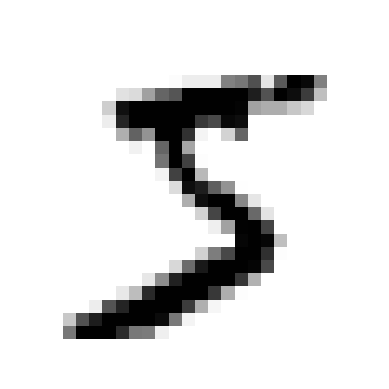

5


In [2]:
import matplotlib.pyplot as plt

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = "binary",)
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

print(y[0])

Now need to seperate training and test set.
The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar

In [3]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Going to simplify the problem and just try to classify between 5 and non-5

In [4]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

Starting with using stochastic gradient desent. This classifier is capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time, which also makes SGD well suited for online learning

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
# print(y_train_5)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [6]:
sgd_clf.predict([some_digit])

array([ True])

# Performance measures

###Cross - validation

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

It looks good but thats because about 90% of the images are non 5 so if you always guess no you will get about 90%. Accuracy is not always the best whit skewed datasets



The code does about the same thing scikit-learns cross_val_score() does

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is
                                       # not already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


###Confusion matrix

In [9]:
from sklearn.model_selection import cross_val_predict

# instead of returning the evaluation scores, it returns the predictions made on each test fold
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53892   687]
 [ 1891  3530]]


Each row repersents a real calss and each column repersents a predicted class.
First row considers non 5s: 53892 correctly and 687 flase positives (type 1 error)
Seccond row considers the 5s: 1,891 wrongly classified as non 5s (type 2 error) and 3,530 correctly classified (true positive)


In [10]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))  # == 3530 / (687 + 3530)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (1891 + 3530)


0.8370879772350012
0.6511713705958311


When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.

We can use the F1 score to combine the classifiers. It uses a harmonic mean giving more weight to low values. Only can get a high F1 if both reacll and percision are high

In [11]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 does favor classifiers that have similar precision and recall.This is not always what you want however. Note incresing percision reduces recall and vice versa (percision/recall trade off)

you can set your own  thresholds as well  

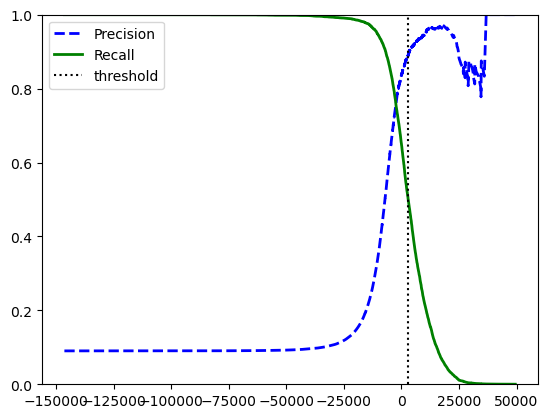

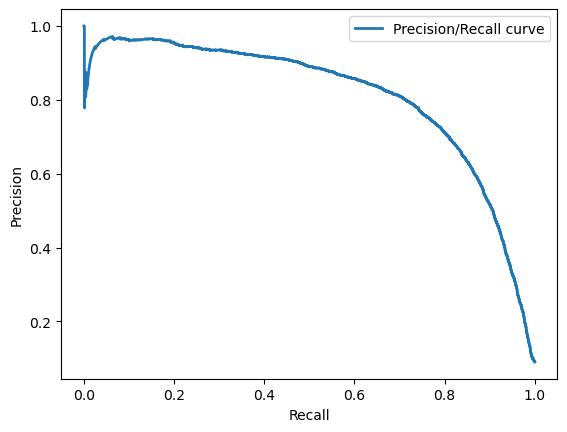

In [12]:
# you can return the decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
threshold = 3000
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.ylim([0, 1])
plt.legend()

plt.show()

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.show()

In [13]:
import numpy as np

idx_90_precision = np.argmax(precisions >= 0.90)
threshold_90_precision = thresholds[idx_90_precision]

print(threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

3370.019499144183
0.9000345901072293
0.4799852425751706


Thats good but has bad recall

### Receiver Operating Characteristic (ROC) curve

another tool for binary classifers. similar to ther precision/recall curve but plots true positive rate(TPR another name for recall) against the false positive rate(FPR or fall-out).  The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

use the roc_curve to find the TPR and FPR for different thresholds

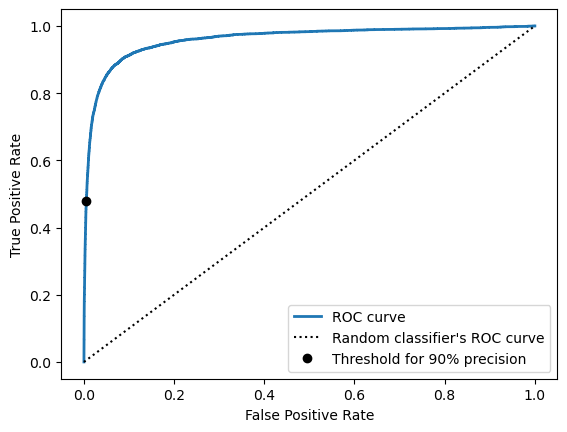

In [14]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


idx_90_precision = (thresholds <= threshold_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_90_precision], fpr[idx_90_precision]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

# a perfect classifer will have a area under the curve of 1 and a pure random will have .5

0.9604938554008616

You should pick PR curve when the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

# Random Forest Classifer



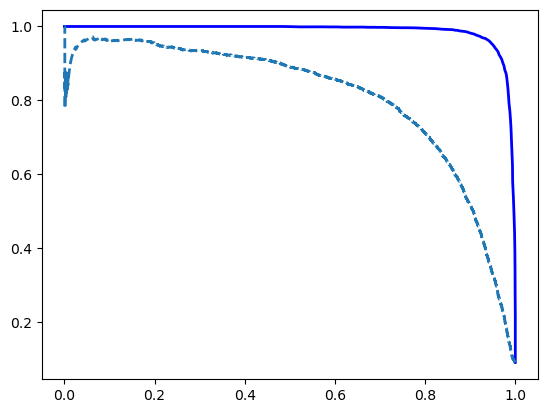

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
# RandomForestClassifier class does not have a decision_function() method so will use predict_proba()

y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)


plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

In [17]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
print("F1 Score:" ,f1_score(y_train_5, y_train_pred_forest))
print("ROC:",roc_auc_score(y_train_5, y_scores_forest))
print("precision:",precision_score(y_train_5, y_train_pred_forest))
print("Recall" ,recall_score(y_train_5, y_train_pred_forest))

F1 Score: 0.9270445185330457
ROC: 0.9983296721818179
precision: 0.9895331798199707
Recall 0.8719793396052389


### Multiclass Classification

Some classifirs can handl multiple classes out of the box like LogisticRegression, RandomForestClassifier, and GaussianNB. Others are binary like SGDClassifire and SVC. However you can preform multiclass classication wth binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on) (Ovr, OvA)

Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy.

In [18]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [19]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
class_id = some_digit_scores.argmax()
print(class_id)
print(svm_clf.classes_)
print(svm_clf.classes_[class_id])

[[ 3.79297828  0.72949369  6.06184129  8.29800527 -0.29383983  9.30157597
   1.74723215  2.77365456  7.20601456  4.82245092]]
5
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


In [20]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [21]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [22]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])


array(['3'], dtype='<U1')

It got it wrong

In [23]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [24]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Can make this better right away with a scaler



In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


array([0.8983, 0.891 , 0.9018])

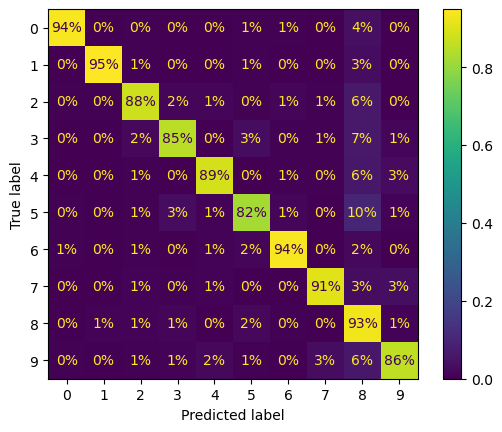

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

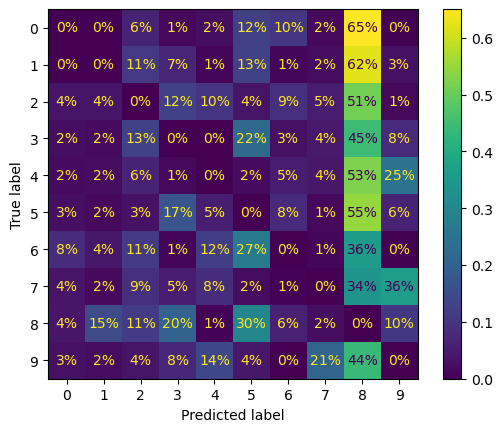

In [29]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"n_neighbors": [3, 4, 5],
              "weights": ["uniform", "distance"]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)


In [45]:
cv_results = grid_search.cv_results_

for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"Mean CV Score: {mean_score:.3f} | Hyperparameters: {params}")

Mean CV Score: 0.970 | Hyperparameters: {'n_neighbors': 3, 'weights': 'uniform'}
Mean CV Score: 0.971 | Hyperparameters: {'n_neighbors': 3, 'weights': 'distance'}
Mean CV Score: 0.969 | Hyperparameters: {'n_neighbors': 4, 'weights': 'uniform'}
Mean CV Score: 0.972 | Hyperparameters: {'n_neighbors': 4, 'weights': 'distance'}
Mean CV Score: 0.969 | Hyperparameters: {'n_neighbors': 5, 'weights': 'uniform'}
Mean CV Score: 0.970 | Hyperparameters: {'n_neighbors': 5, 'weights': 'distance'}


In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

best_params = grid_search.best_params_
print(best_params)

best_model = grid_search.best_estimator_
print(best_model)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")


{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=4, weights='distance')
Accuracy: 0.9714


## Data Augmentation

In [48]:
from scipy.ndimage.interpolation import shift

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0,-1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)



/var/folders/g5/dpll23qx4l5245c7p6n4jx8c0000gn/T/ipykernel_4479/827691556.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift


In [49]:
X_train_augmented.shape

(300000, 784)

In [51]:
knn_clf = KNeighborsClassifier(**best_params)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [52]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [53]:
error_rate_change = (1 - augmented_accuracy) / (1 - accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%
